In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from summer2 import CompartmentalModel
from summer2.parameters import Parameter, DerivedOutput

In [2]:
def build_demog_model(
    config: dict,
) -> CompartmentalModel:
    
    # Model characteristics
    compartments = (
        "Susceptible", 
        "Pre-infectious", 
        "Infectious", 
        "Immune"
    )
    model = CompartmentalModel(
        times=(0., config["end_time"]),
        compartments=compartments,
        infectious_compartments=["Infectious"],
    )
    model.set_initial_population(
        distribution={
            "Susceptible": config["total_population"] - config["infectious_seed"],
            "Infectious": config["infectious_seed"],
        }
    )
    
    # Transitions
    infectious_period = Parameter("infectious_period")
    model.add_infection_frequency_flow(
        name="infection", 
        contact_rate=Parameter("r0") / infectious_period,
        source="Susceptible", 
        dest="Pre-infectious"
    )
    model.add_transition_flow(
        name="progression", 
        fractional_rate=1. / Parameter("latent_period"),
        source="Pre-infectious", 
        dest="Infectious"
    )
    model.add_transition_flow(
        name="recovery", 
        fractional_rate=1. / infectious_period,
        source="Infectious", 
        dest="Immune",
    )
    model.add_replacement_birth_flow(
        "births",
        "Susceptible",
    )
    model.add_universal_death_flows(
        "universal_death",
        death_rate=1. / Parameter("life_expectancy") / 365.,
    )
    
    # Outputs
    model.request_output_for_compartments(
        name="infectious",
        compartments="Infectious",
    )
    
    model.request_output_for_compartments(
        name="total_population",
        compartments=compartments,
    )
    model.request_function_output(
        name="prevalence",
        func=DerivedOutput("infectious") / DerivedOutput("total_population") * 1e5,
    )
        
    return model

In [3]:
model_config = {
    "end_time": 100. * 365.,
    "total_population": 1e5,
    "infectious_seed": 1.,
}

parameters = {
    "latent_period": 8.,
    "infectious_period": 7.,
    "r0": 13.,
    "life_expectancy": 70.,
}

In [4]:
seir_demog_model = build_demog_model(model_config)
seir_demog_model.run(parameters=parameters, solver="euler")
outputs = seir_demog_model.get_outputs_df()
prevalence = seir_demog_model.get_derived_outputs_df()["prevalence"]

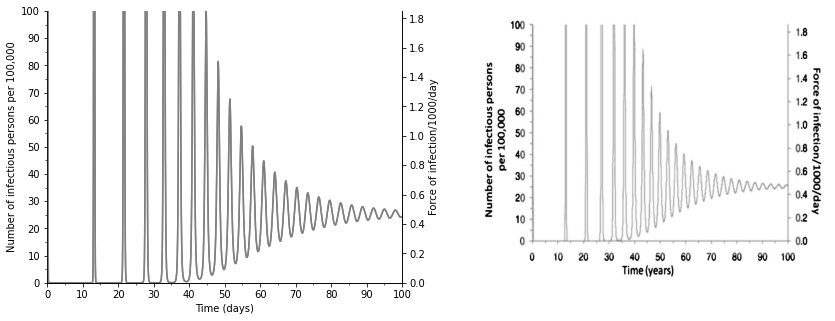

In [5]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))
twin_ax = left_ax.twinx()

left_ax.plot(
    seir_demog_model.times / 365., 
    prevalence,
    color="0.5",
)
left_ax.set_xlim(0., 100.)
left_ax.set_xticks(range(0, 110, 10))
left_ax.set_xlabel("Time (days)")
left_ax.xaxis.set_minor_locator(AutoMinorLocator(2))
left_ax.set_ylim(0, 100.)
left_ax.set_yticks(range(0, 110, 10))
left_ax.yaxis.set_minor_locator(AutoMinorLocator(2))
left_ax.set_ylabel("Number of infectious persons per 100,000")
left_ax.spines.top.set_visible(False)

force_of_infection = prevalence * parameters["r0"] / parameters["infectious_period"] / model_config["total_population"] * 1e3

twin_ax.plot(
    seir_demog_model.times / 365., 
    force_of_infection, 
    color="0.5",
)
twin_ax.set_ylim(0., 1.85)
twin_ax.set_yticks(np.linspace(0, 1.8, 10))
twin_ax.set_ylabel("Force of infection/1000/day")
twin_ax.spines.top.set_visible(False)

image = plt.imread("./figures/fig_5_2.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");